# Preamble

In [1]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Generation
$$
m \sim \pi(m|\vec{\lambda}) = f_1 N(m|\mu_1, \sigma_1) + (1-f_1) N(m|\mu_2, \sigma_2)
$$

In [2]:
f1 = 0.7
mu1 = 34.0
sigma1 = 3.0
mu2 = 55.0
sigma2 = 1.0

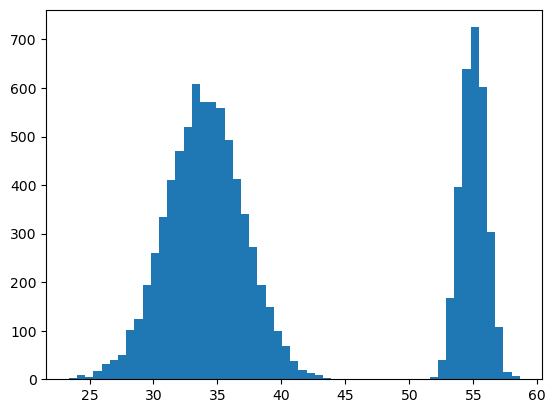

In [3]:
Nobs = 10000
rnd = np.random.uniform(0.0, 1.0, Nobs)
sel = f1>rnd
m1 = np.random.normal(mu1, sigma1, Nobs)
m2 = np.random.normal(mu2, sigma2, Nobs)
m = sel*m1 + (1-sel)*m2
np.random.shuffle(m)
_ = plt.hist(m, bins=55)

# Inference With Truth

In [4]:
def make_model(m):
    
    with pm.Model() as model:
        
        f1 = pm.Uniform('f1', 0.1, 0.9)
        mu1 = pm.Uniform('mu1', 30.0, 40.0)
        sigma1 = pm.Uniform('sigma1', 1.0, 6.0)
        mu2 = pm.Uniform('mu2', 50.0, 60.0)
        sigma2 = pm.Uniform('sigma2', 0.1, 5.0)

        var = f1*at.exp(pm.logp(pm.Normal.dist(mu1, sigma1), m)) + (1-f1)*at.exp(pm.logp(pm.Normal.dist(mu2, sigma2), m))
        pm.Potential('var', at.sum(at.log(var)))
        
    return model

In [5]:
tune = 1000
target_accept = 0.99
with make_model(m) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f1, mu1, sigma1, mu2, sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.


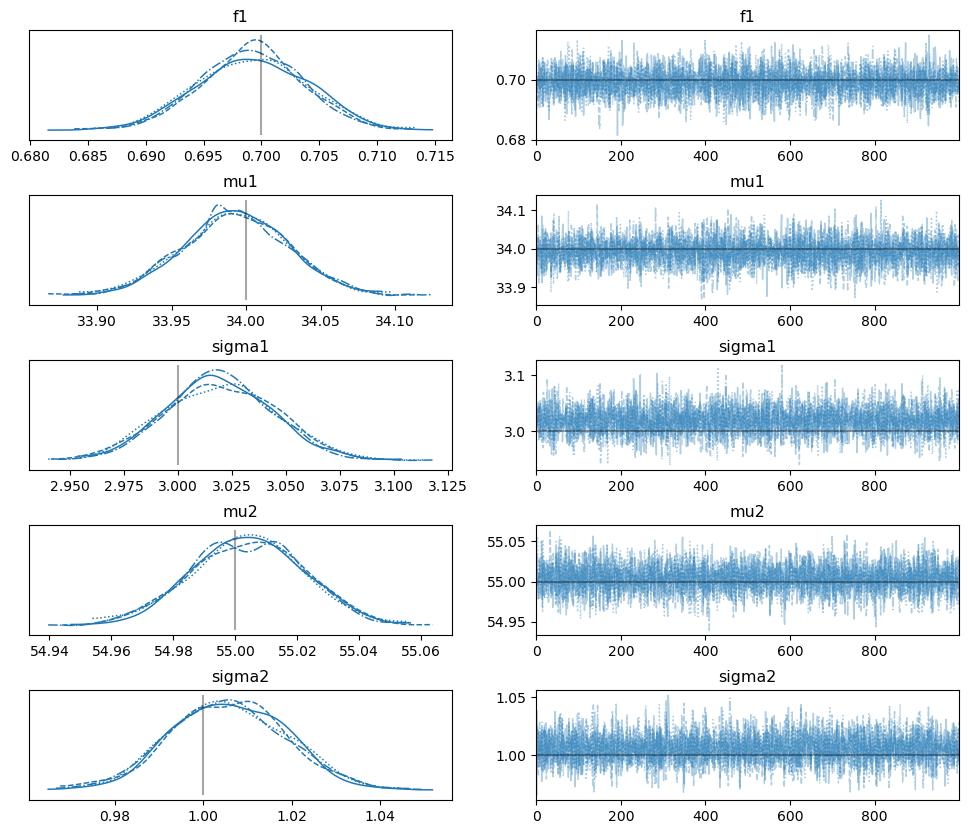

In [6]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['f1', 'mu1', 'sigma1', 'mu2', 'sigma2'],
                        lines=[('f1', {}, 0.7),
                        ('mu1', {}, 34.0),
                        ('sigma1', {}, 3.0),
                        ('mu2', {}, 55.0),
                        ('sigma2', {}, 1.0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

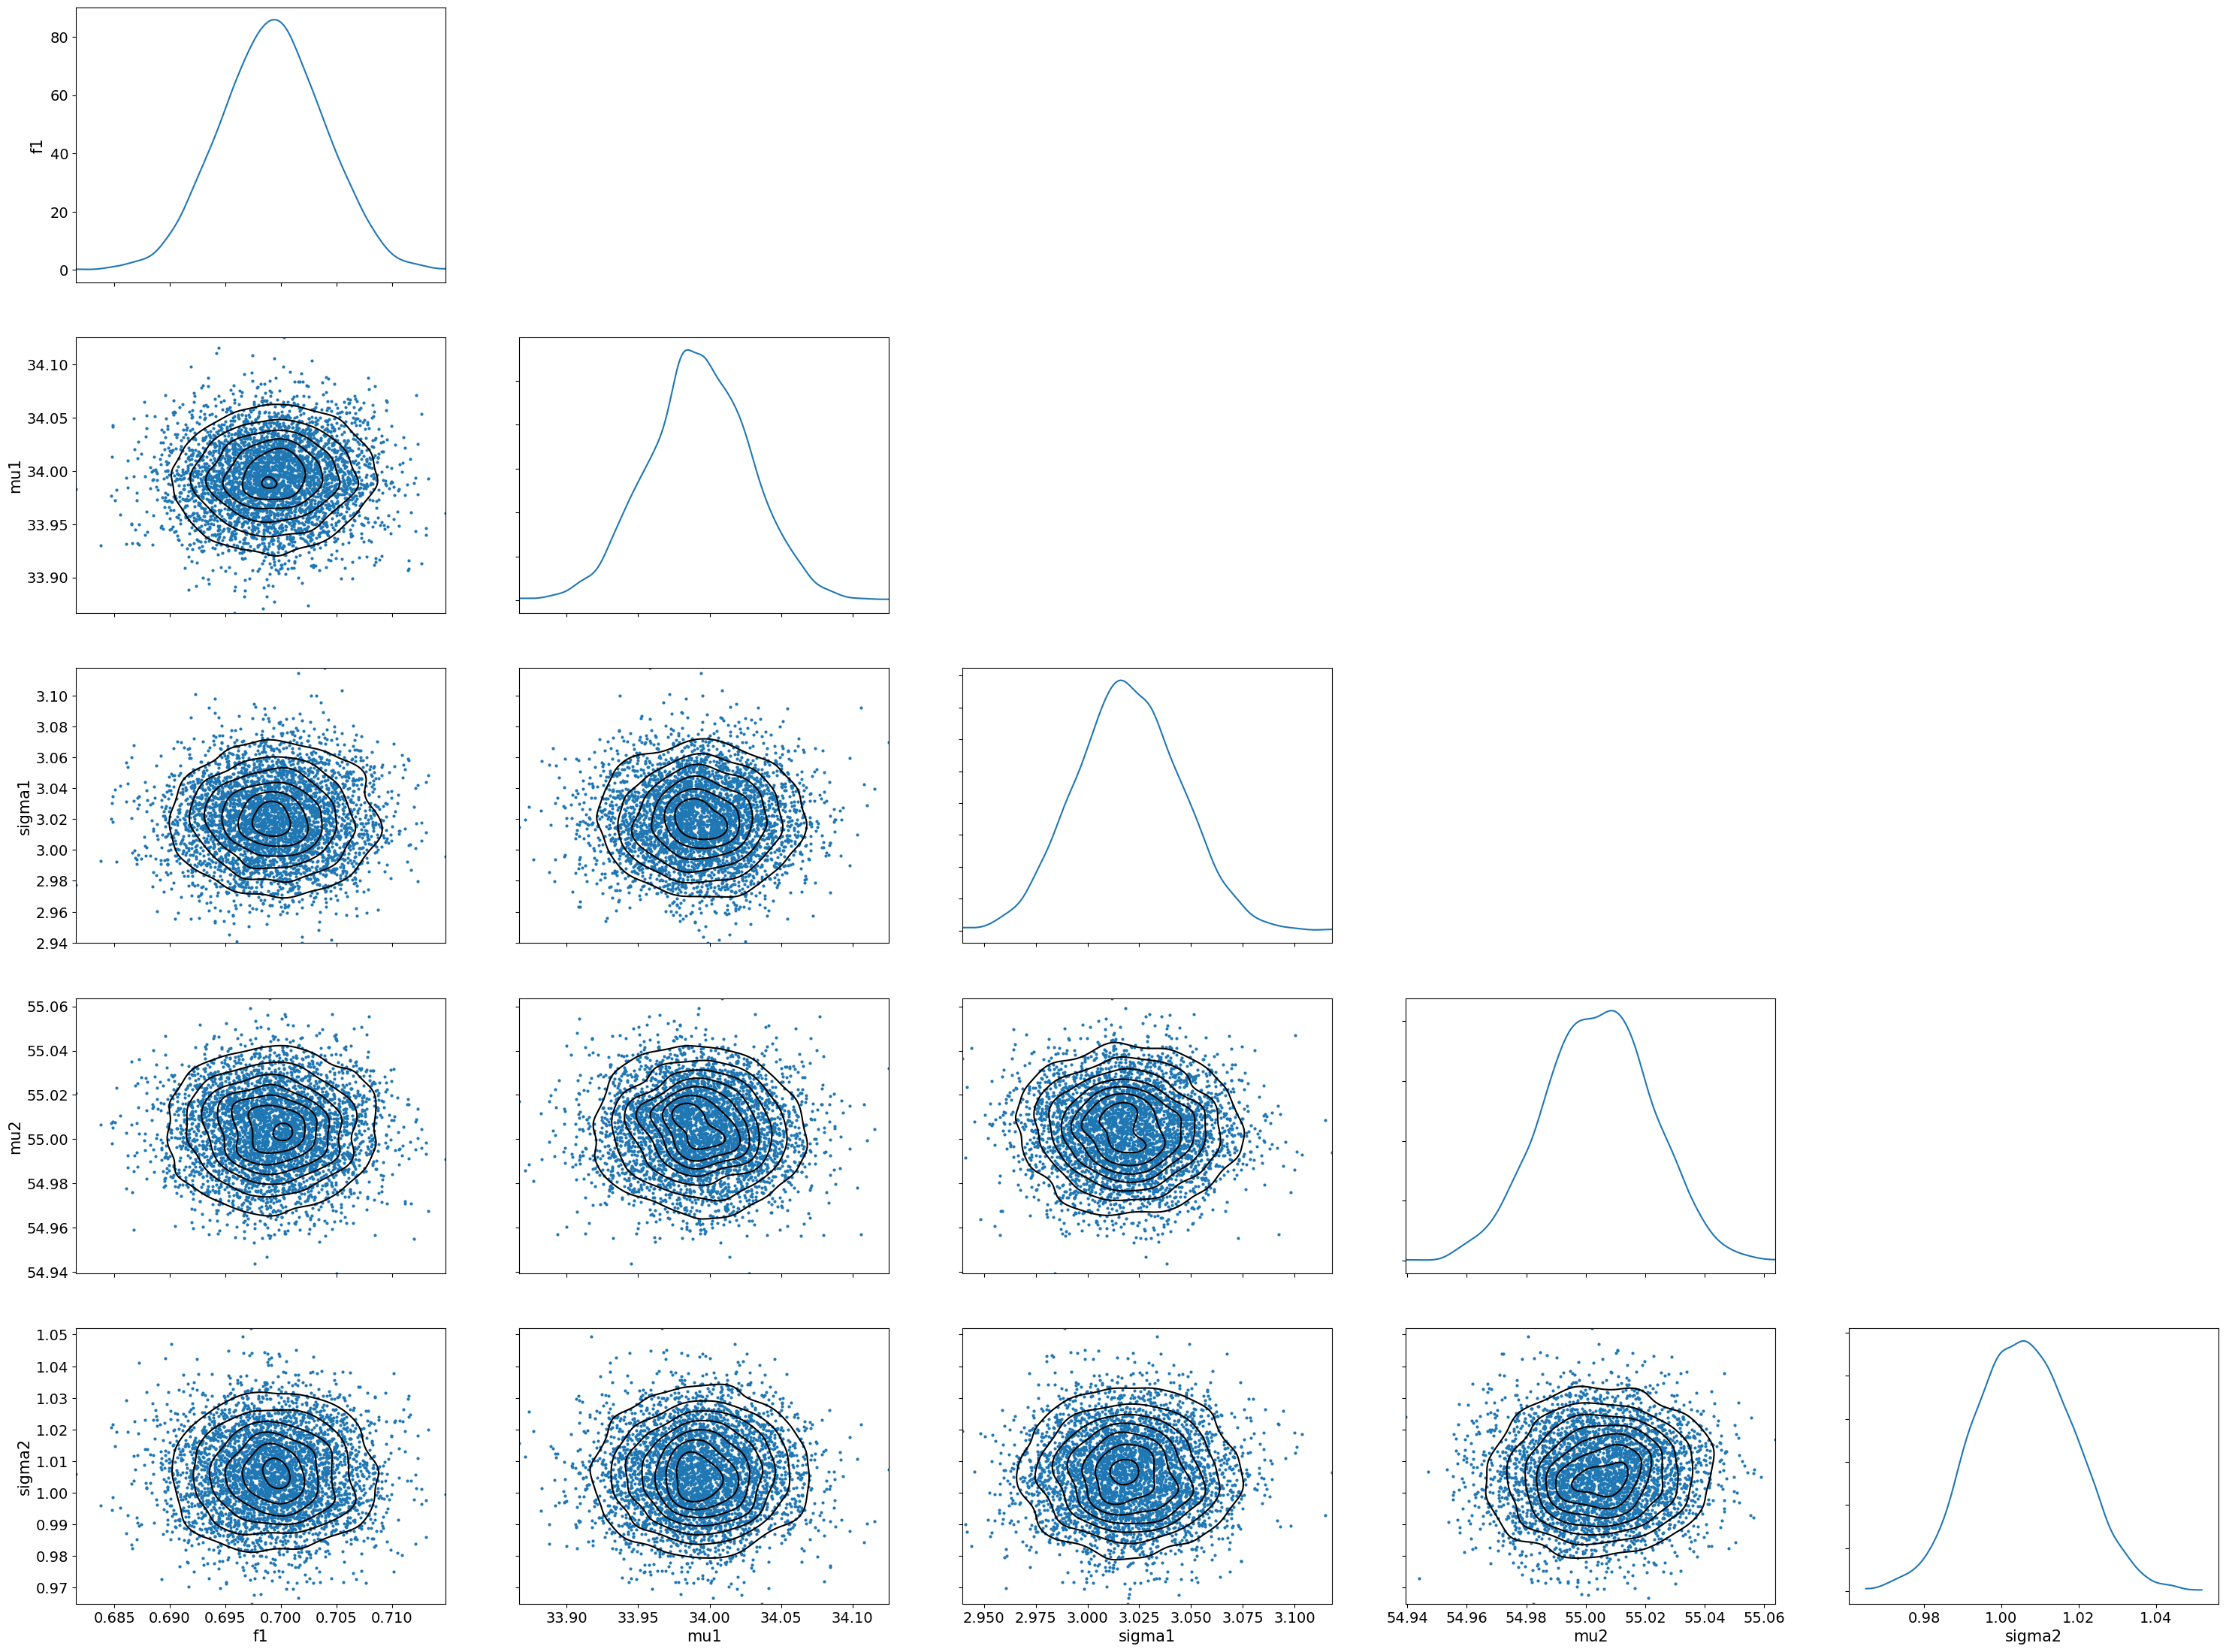

In [7]:
axes1 = az.plot_pair(trace, var_names=['f1', 'mu1', 'sigma1', 'mu2', 'sigma2'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Introduce Cut to the Truth

In [8]:
def make_model1(m):
    
    with pm.Model() as model:

        mu2 = pm.Uniform('mu2', 47.0, 70.0)
        sigma2 = pm.Uniform('sigma2', 0.1, 7.0)

        var = pm.logp(pm.Normal.dist(mu2, sigma2), m)
        pm.Potential('var', at.sum(var))
        
    return model

In [9]:
tune = 1000
target_accept = 0.99
with make_model1(m[m>50.0]) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu2, sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


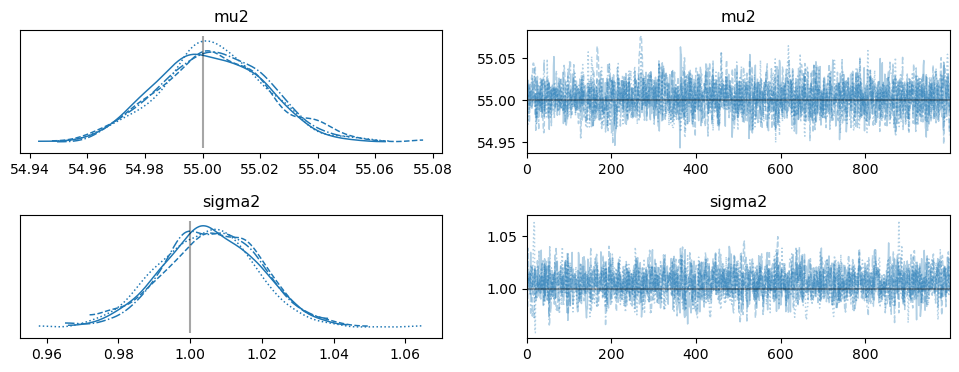

In [10]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu2', 'sigma2'],
                        lines=[('mu2', {}, 55.0),
                        ('sigma2', {}, 1.0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

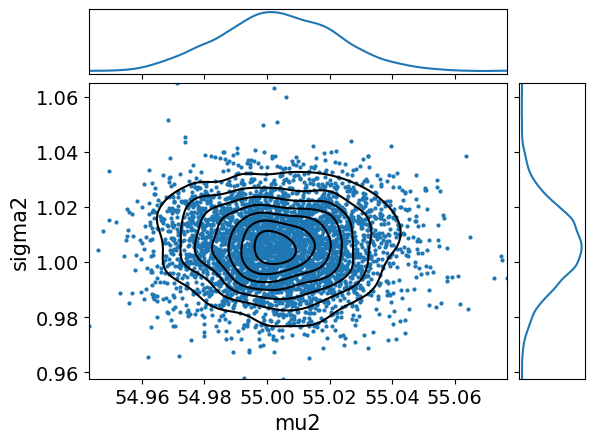

In [11]:
axes1 = az.plot_pair(trace, var_names=['mu2', 'sigma2'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Errorbars

$$
P(m_{obs}|m) = N(m_{obs}|m, sigma)
$$

In [12]:
sigma_pe = 5.0
mobs = np.random.normal(m,sigma_pe)
mobs.shape

(10000,)

# Inference With Errorbars

$$
P(\vec{\lambda}|m_{obs}) \propto \pi(\vec{\lambda}) \prod_{obs} \int_{m} dm P(m_{obs}|m) \pi(m|\vec{\lambda})
$$

$$
= \pi(\vec{\lambda}) \prod_{obs} \int_{m} dm N(m|m_{obs}, sigma)(f_1N(m|\mu_1, \sigma_1) + (1-f_1)N(m|\mu_2, \sigma_2))
$$

$$
= \pi(\vec{\lambda}) \prod_{obs} (f_1N(m_{obs}|\mu_1, \sqrt{\sigma_1^2+\sigma^2}) + (1-f_1)N(m_{obs}|\mu_2, \sqrt{\sigma_2^2 + \sigma^2}))
$$

In [13]:
def make_model2(mobs, sigma):
    
    with pm.Model() as model:
        
        f1 = pm.Uniform('f1', 0.1, 0.9)
        mu1 = pm.Uniform('mu1', 30.0, 40.0)
        sigma1 = pm.Uniform('sigma1', 1.0, 6.0)
        mu2 = pm.Uniform('mu2', 50.0, 60.0)
        sigma2 = pm.Uniform('sigma2', 0.1, 5.0)

        sigma11 = at.sqrt(sigma**2 + sigma1**2)
        sigma22 = at.sqrt(sigma**2 + sigma2**2)
        var = f1*at.exp(pm.logp(pm.Normal.dist(mu1, sigma11), mobs)) + (1-f1)*at.exp(pm.logp(pm.Normal.dist(mu2, sigma22), mobs))
        pm.Potential('var', at.sum(at.log(var)))
        
    return model

In [14]:
tune = 1000
target_accept = 0.99
with make_model2(mobs, sigma=sigma_pe) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f1, mu1, sigma1, mu2, sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.


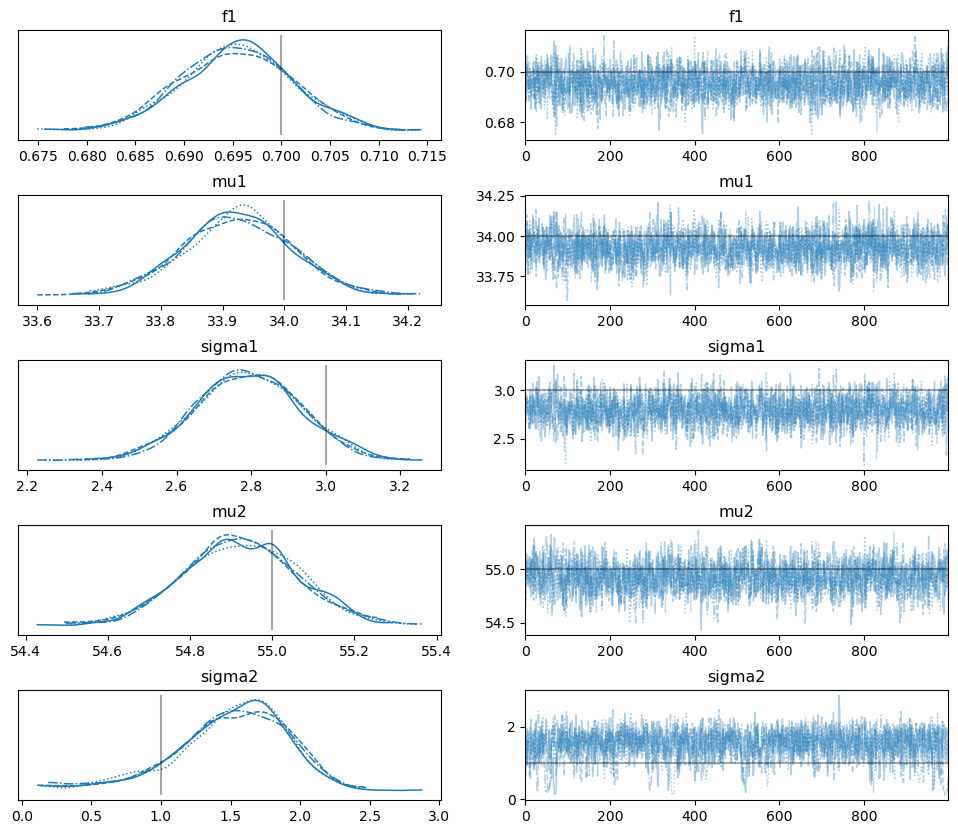

In [15]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['f1', 'mu1', 'sigma1', 'mu2', 'sigma2'],
                        lines=[('f1', {}, 0.7),
                        ('mu1', {}, 34.0),
                        ('sigma1', {}, 3.0),
                        ('mu2', {}, 55.0),
                        ('sigma2', {}, 1.0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

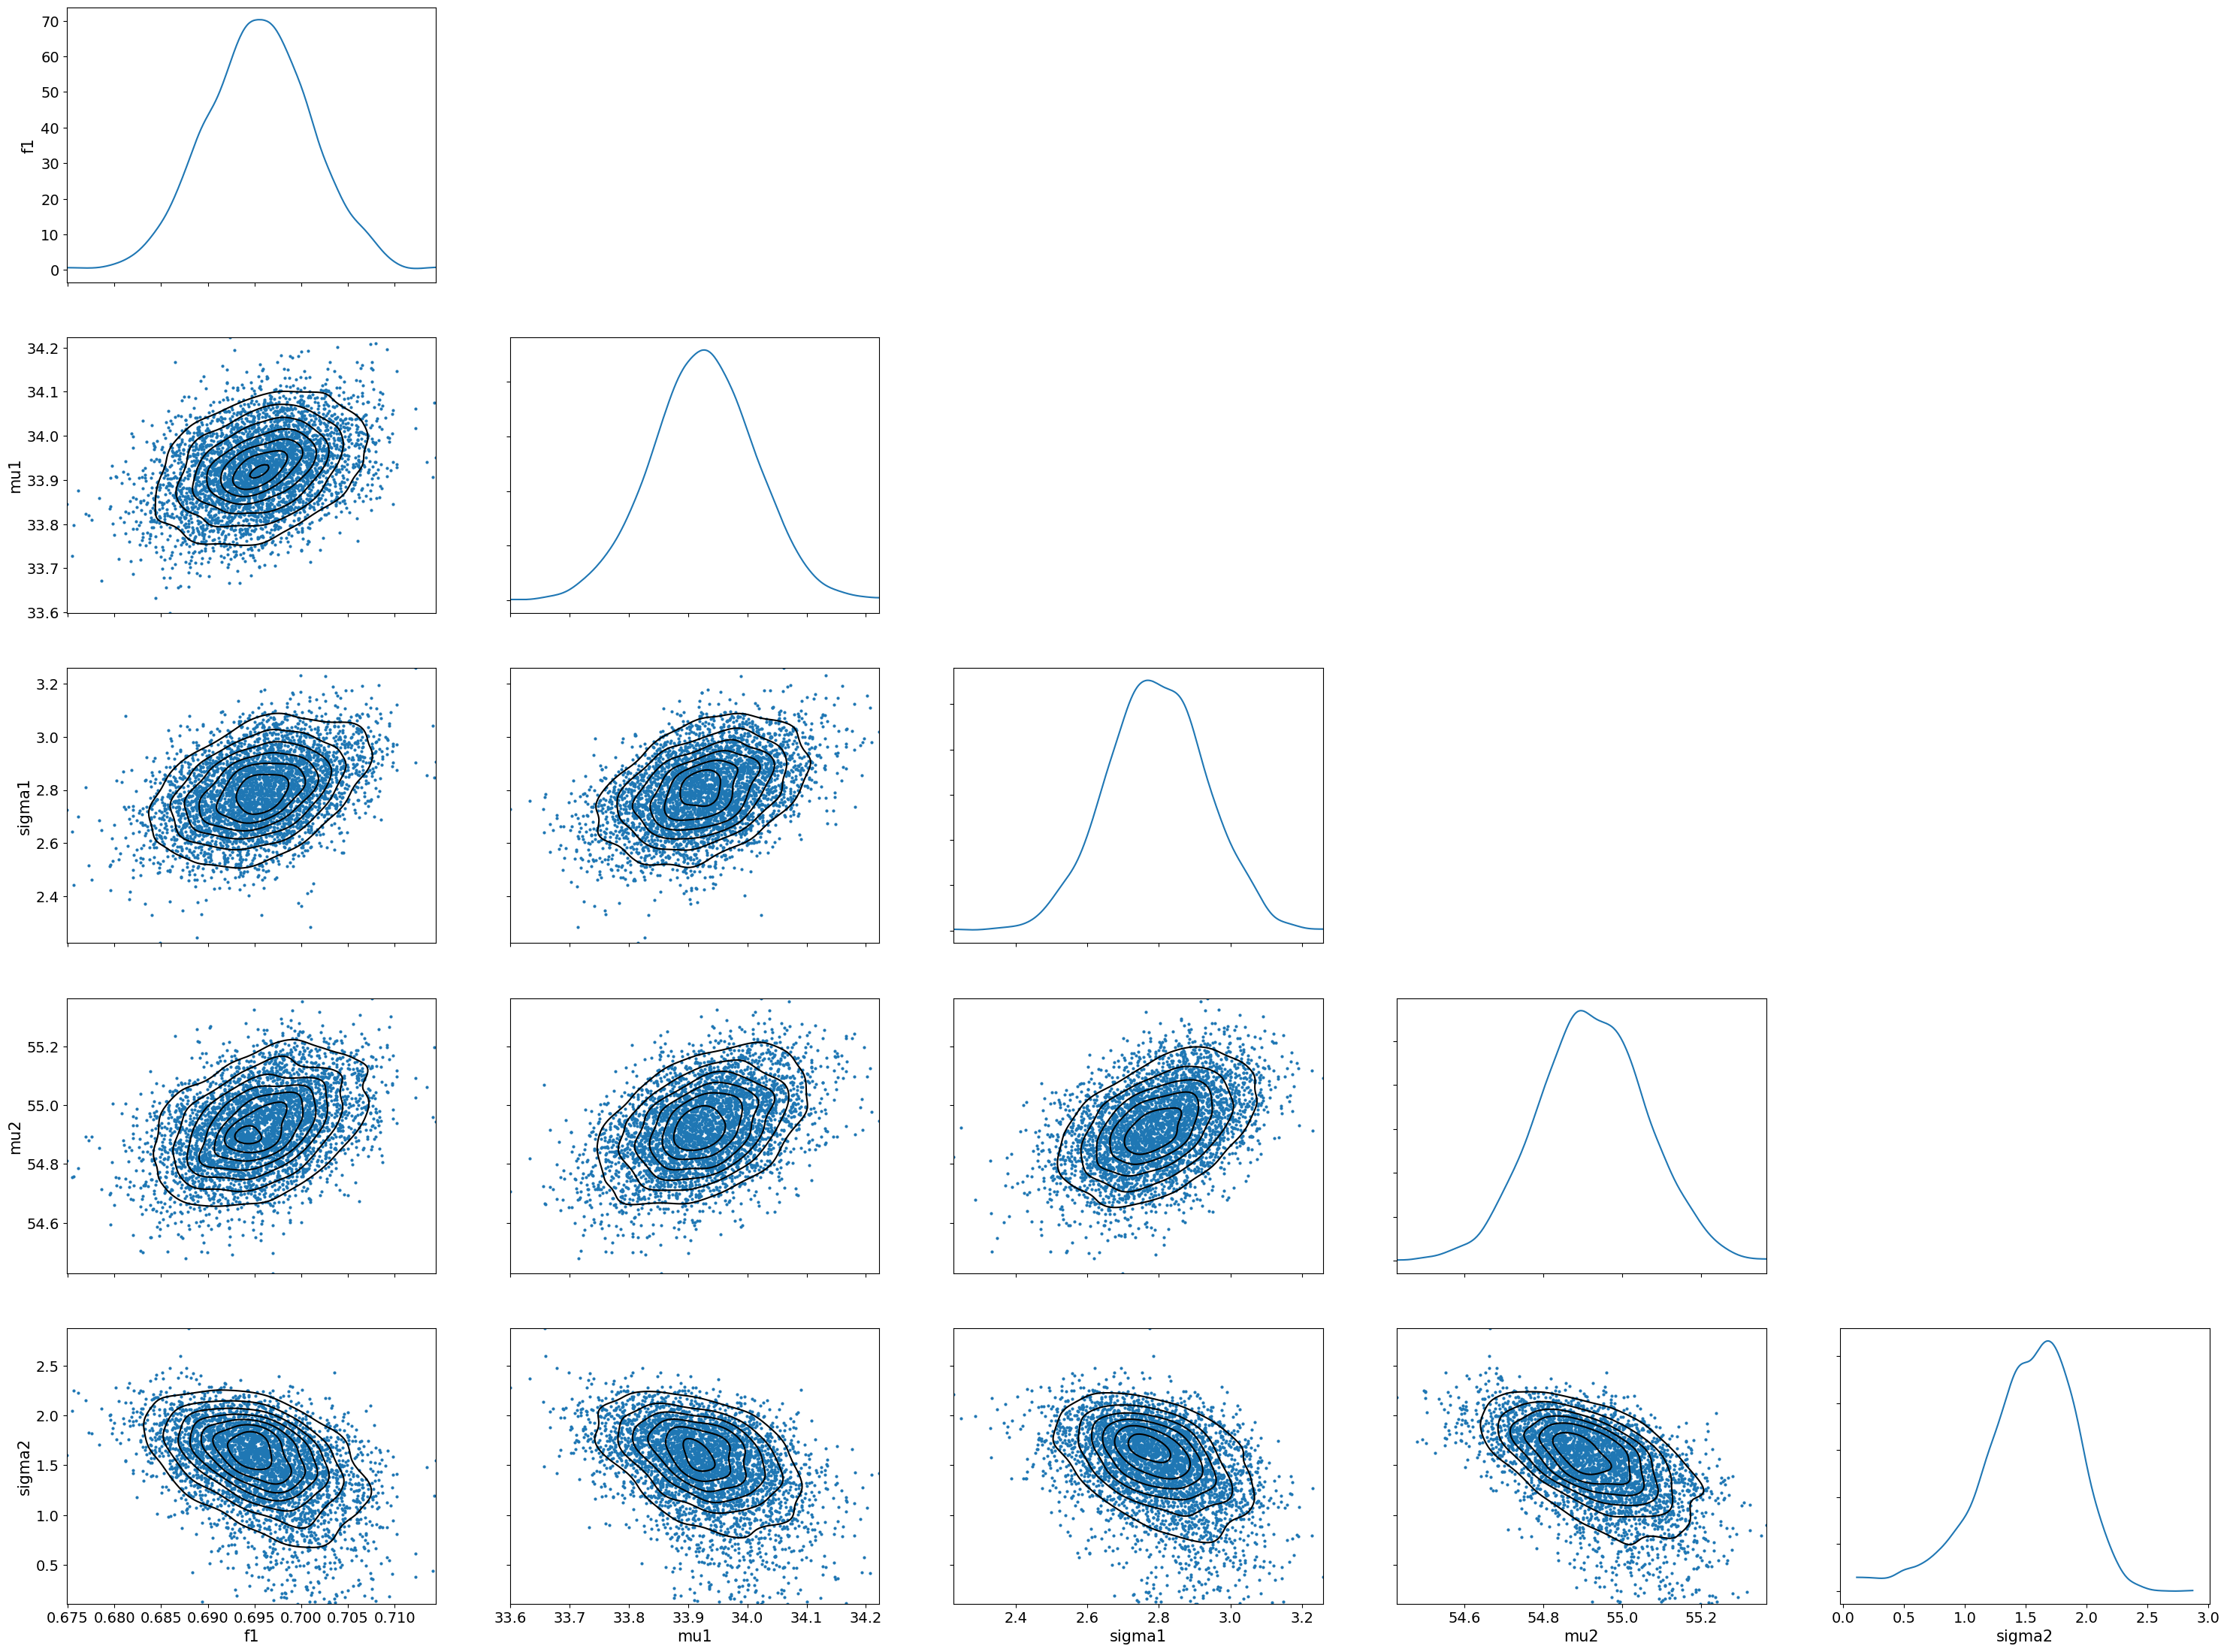

In [16]:
axes1 = az.plot_pair(trace, var_names=['f1', 'mu1', 'sigma1', 'mu2', 'sigma2'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Don't Model the Higher Mass Peak

In [17]:
def make_model3(mobs, sigma):
    
    with pm.Model() as model:

        mu1 = pm.Uniform('mu1', 20.0, 70.0)
        sigma1 = pm.Uniform('sigma1', 0.1, 20.0)

        sigma11 = at.sqrt(sigma**2+sigma1**2)
        var = pm.logp(pm.Normal.dist(mu1, sigma11), mobs)
        pm.Potential('var', at.sum(var))
        
    return model

In [18]:
tune = 1000
target_accept = 0.99
with make_model3(mobs, sigma=sigma_pe) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


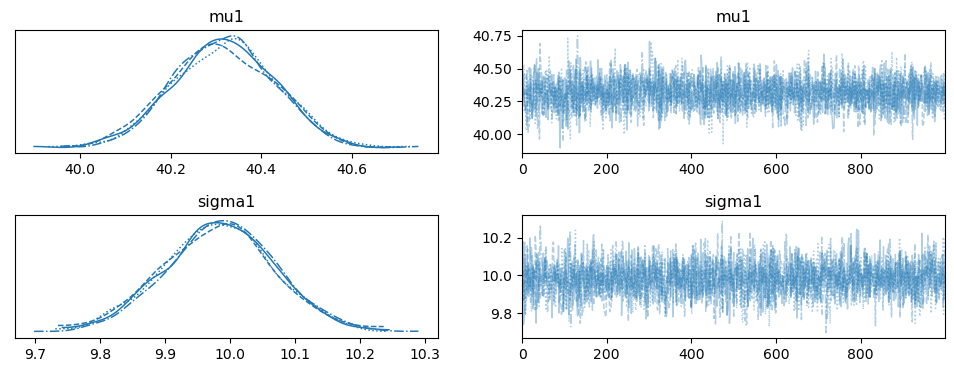

In [19]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu1', 'sigma1'])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

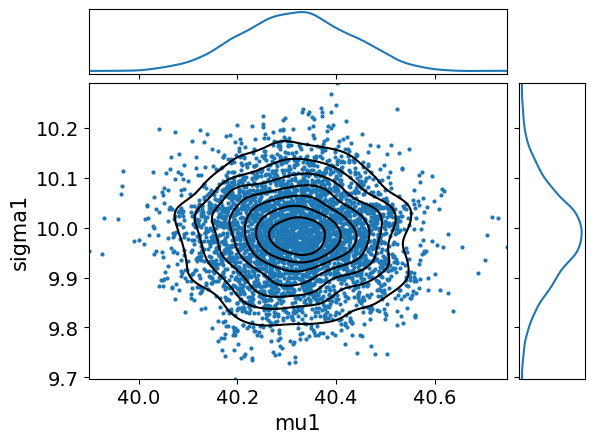

In [20]:
axes1 = az.plot_pair(trace, var_names=['mu1', 'sigma1'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Biased!

# Introduce Cut to the Obs

# Lower Mass Peak

In [21]:
def make_model4(mobs, sigma):
    
    with pm.Model() as model:

        mu1 = pm.Uniform('mu1', 20.0, 50.0)
        sigma1 = pm.Uniform('sigma1', 0.1, 20.0)

        sigma11 = at.sqrt(sigma**2+sigma1**2)
        var = pm.logp(pm.Normal.dist(mu1, sigma11), mobs)
        pm.Potential('var', at.sum(var))
        
    return model

In [22]:
tune = 1000
target_accept = 0.99
with make_model4(mobs[mobs<50.0], sigma=sigma_pe) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


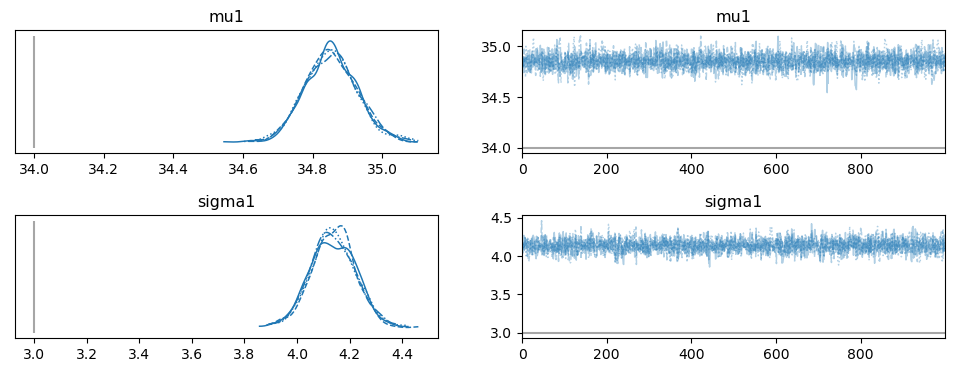

In [23]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu1', 'sigma1'],
                        lines=[('mu1', {}, 34.0),
                        ('sigma1', {}, 3.0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

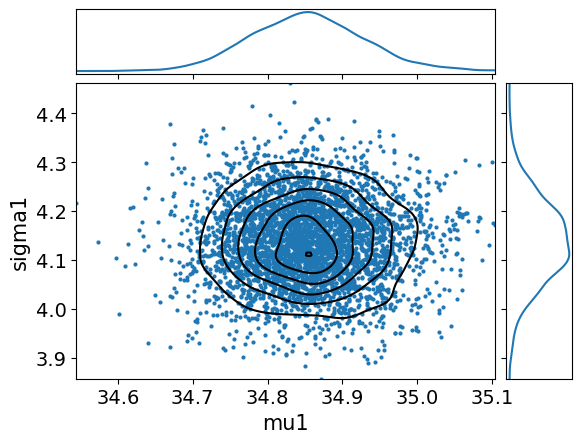

In [24]:
axes1 = az.plot_pair(trace, var_names=['mu1', 'sigma1'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Biased!

# Higher Mass Peak

In [29]:
def make_model5(mobs, sigma):
    
    with pm.Model() as model:

        mu2 = pm.Uniform('mu2', 50.0, 70.0)
        sigma2 = pm.Uniform('sigma2', 0.001, 10.0)

        sigma22 = at.sqrt(sigma**2+sigma2**2)
        var = pm.logp(pm.Normal.dist(mu2, sigma22), mobs)
        pm.Potential('var', at.sum(var))
        
    return model

In [30]:
tune = 1000
target_accept = 0.99
with make_model5(mobs[mobs>50.0], sigma=sigma_pe) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu2, sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


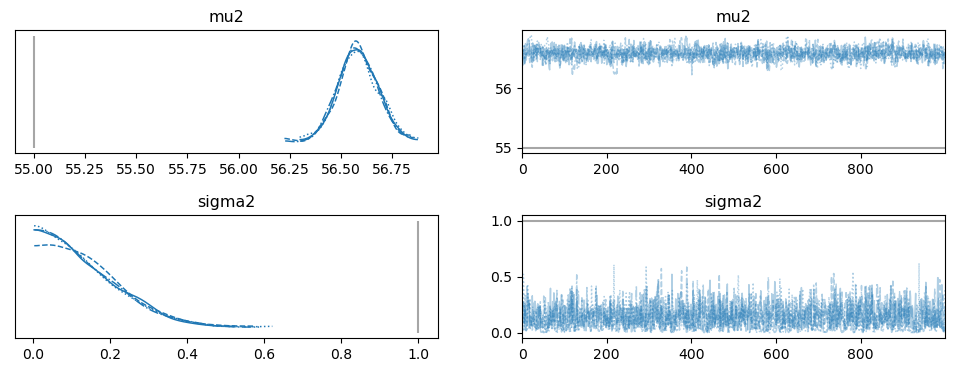

In [31]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu2', 'sigma2'],
                        lines=[('mu2', {}, 55.0),
                        ('sigma2', {}, 1.0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

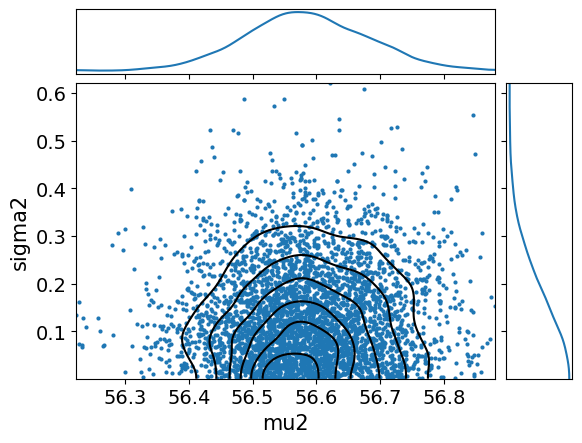

In [32]:
axes1 = az.plot_pair(trace, var_names=['mu2', 'sigma2'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Biased!

In [37]:
import h5py
with h5py.File("mass_data.h5", "w") as file:
    file.create_dataset('mobs', data=mobs)
file.close()

# Introduce Cut with Normalisation

If we don't have cut in $m_{obs}$, then:
$$
\mathcal{L}(m_{obs}|\vec{\lambda}) = \int_{-\infty}^{\infty} dm \mathcal{L}(m_{obs}|m) \pi (m|\vec{\lambda})
$$
where $-\infty < m_{obs} < \infty$ for $\pi (m|\vec{\lambda}) = f_1 N(m|\mu_1, \sigma_1) + (1-f_1) N(m|\mu_2, \sigma_2)$.

After introducing a lowercut at $m_{obs} = m_{min}$,
$$
\mathcal{L}(m_{obs}|\vec{\lambda}) = c\int_{m_{min}}^{\infty} dm \mathcal{L}(m_{obs}|m) \pi (m|\vec{\lambda})
$$
where $c$ is the normalisation constant and $m_{min} < m_{obs} < \infty$ for $\pi (m|\vec{\lambda}) = N(m|\mu_2, \sigma_2)$.

To calculate $c$, note:
$$
\int_{m_{min}}^{\infty} dm_{obs} \mathcal{L}(m_{obs}|\vec{\lambda}) = 1
$$

To do the $m$ integral analytically, we assume $m_{min}$ is far from $\mu_2$:
$$
\frac{m_{min}-\mu_2}{\sigma_2} << 1
$$
then, $\pi(m_{min}|\vec{\lambda}) \rightarrow 0$.

$c$ comes out to be,
$$
c = \frac{1}{1-F\Big ( \frac{m_{min}-\mu_2}{\sqrt{\sigma^2+\sigma_2^2}} \Big)}
$$
where $F(.)$ is the cdf of standard normal distribution.

Hence the full likelihood:
$$
\mathcal{L}(m_{obs}|\vec{\lambda}) = \Bigg(\frac{1}{1-F\Big ( \frac{m_{min}-\mu_2}{\sqrt{\sigma^2+\sigma_2^2}} \Big)}\Bigg) N(m_{obs}|\mu_2, \sqrt{\sigma^2 + \sigma^2})
$$
given the normal PE likelihood $\mathcal{L}(m_{obs}|m) = N(m_{obs}|m,\sigma)$.

# Special Case
$$
\sigma \rightarrow 0 \Rightarrow \mathcal{L}(m_{obs}|m) = \delta (m_{obs}-m)
$$

If the PE errorbar is very small compared to $\sigma_2$,
$$
F\Big ( \frac{m_{min}-\mu_2}{\sqrt{\sigma^2+\sigma_2^2}} \Big) \rightarrow 0
$$
given we give the cut far from feature in the population $N(m_{min}|\mu_2,\sigma_2) \rightarrow 0$.

It gives
$$
c = 1
$$

# Hyperposterior
$$
P(\vec{\lambda}|m_{obs}) \propto \pi(\vec{\lambda}) \Bigg(\frac{1}{1-F\Big ( \frac{m_{min}-\mu_2}{\sqrt{\sigma^2+\sigma_2^2}} \Big)}\Bigg)^{N_{obs}} \prod_{obs} (N(m_{obs}|\mu_2, \sqrt{\sigma_2^2 + \sigma^2}))
$$

We switch to jax+numpyro sampling now. See 'intensity.py' for the model and 'result.ipynb' for the result.